# Table Of Contents:

### 1. [Data Load](#1)
### 2. [Train/Test Split](#2)
### 3. [Modeling - ARIMA](#3)
>a. [ARIMA Results](#3.a)
### 4. [Modeling - Facebook Prophet](#4)
>a. [Prophet Results](#4.a)
### 5. [Comparative Analysis](#5)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

## Data Load <a class="anchor" id="data-load"></a>

In [2]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*7)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

stock= 'GOOGL'

df = yf.download(stock, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1754,2024-07-19,178.880005,180.289993,177.130005,177.660004,177.660004,18881900
1755,2024-07-22,180.589996,182.699997,180.229996,181.669998,181.669998,24100300
1756,2024-07-23,182.050003,183.610001,181.539993,181.789993,181.789993,36352700
1757,2024-07-24,173.600006,176.190002,171.820007,172.630005,172.630005,49585200
1758,2024-07-25,172.520004,173.419998,167.190002,167.279999,167.279999,44852000


In [3]:
df_close = df[['Date', 'Close']]
df_close.set_index("Date", inplace=True)
df_close.head()

,Close
Date,
2017-07-28,47.916500
2017-07-31,47.275002
2017-08-01,47.327999
2017-08-02,47.382000
2017-08-03,47.014999


## Train/Test Split <a class="anchor" id="2"></a>

Train, Test split on 80% of the data

In [4]:
train_data, test_data = df_close[3:int(len(df_close)*0.8)], df_close[int(len(df_close)*0.8):]

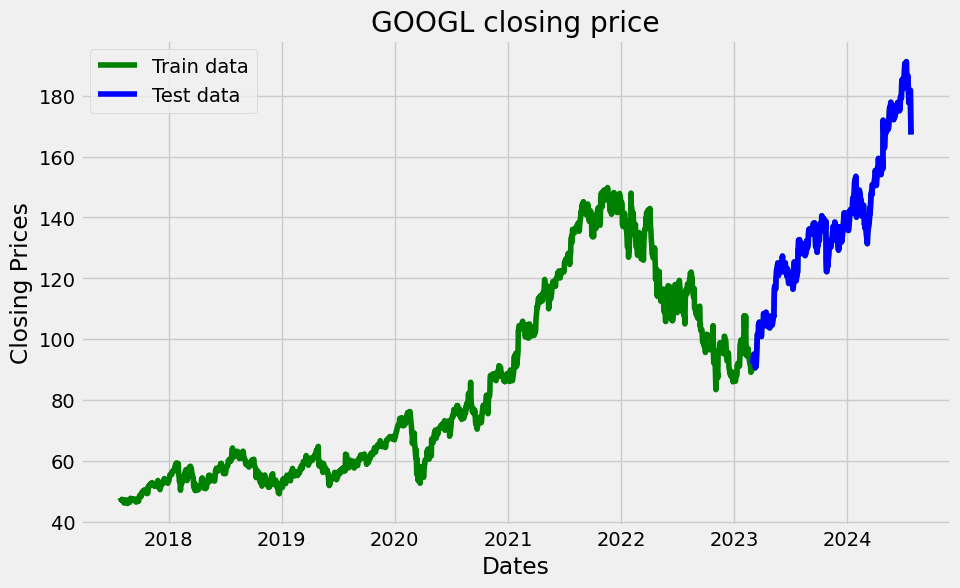

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('{} closing price'.format(stock))
plt.legend()

<Figure size 640x480 with 0 Axes>

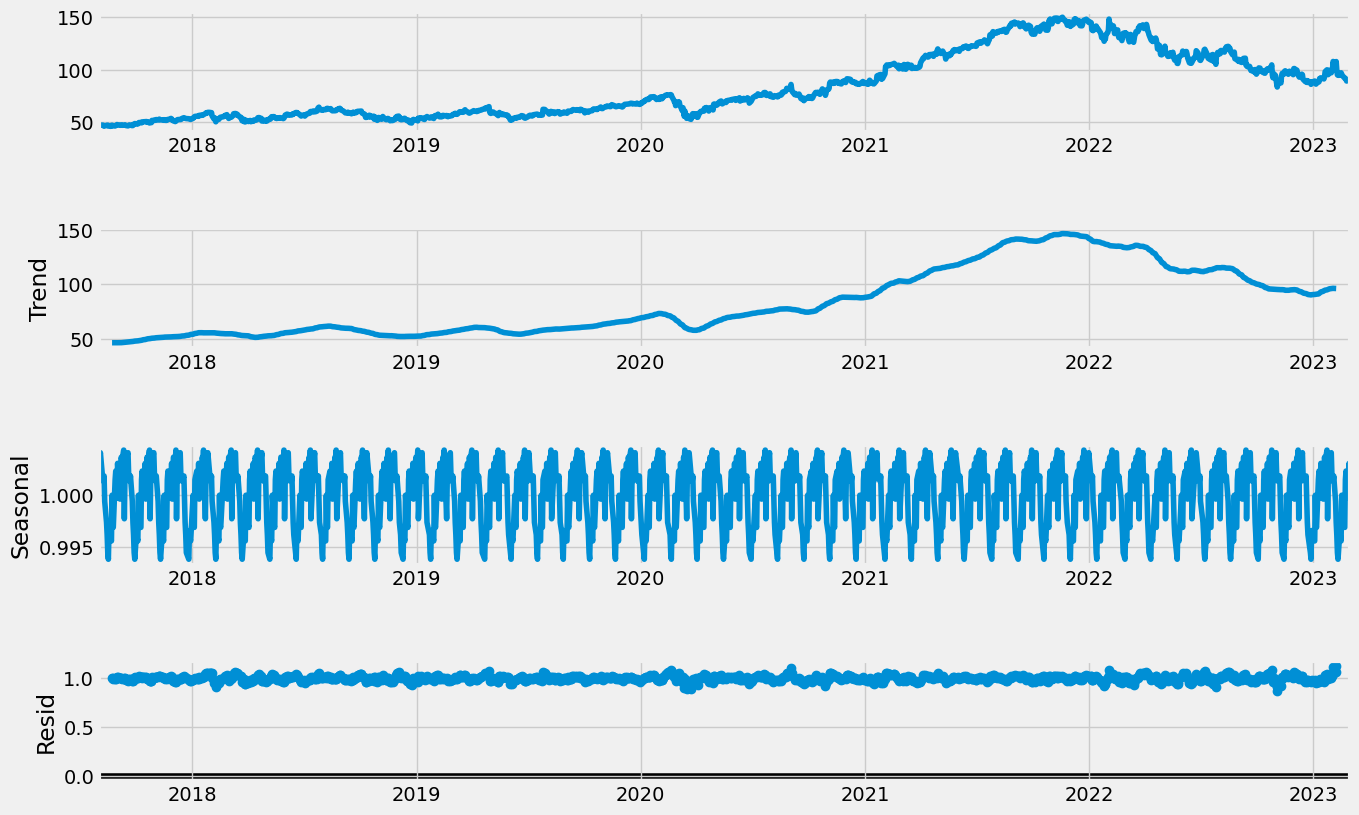

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Our data has seasonality 

We need to test for stationarity<br>

Null Hypothesis (H0): The time series has is non-stationary <br>
Alternative Hypothesis (H1): The time series it is stationary

In [7]:
#Log data to remove ttrend effect
train_data_log = np.log(train_data)
train_data_log.head()

In [8]:
train_data_adf = adfuller(train_data_log)
print('ADF Statistic (Differenced Series):', train_data_adf[0])
print('p-value (Differenced Series):', train_data_adf[1])

Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This means that the differenced series is likely non-stationary. We are going to apply differencing

In [9]:
train_data_log_diff = train_data_log.diff().dropna()

In [10]:
train_data_log_diff_adf = adfuller(train_data_log_diff)
print('ADF Statistic (Differenced Series):', train_data_log_diff_adf[0])
print('p-value (Differenced Series):', train_data_log_diff_adf[1])

After applying differencing, our new p-value is smaller than 0.05. Therefore we reject the null hypothesis, this mean our series is stationary

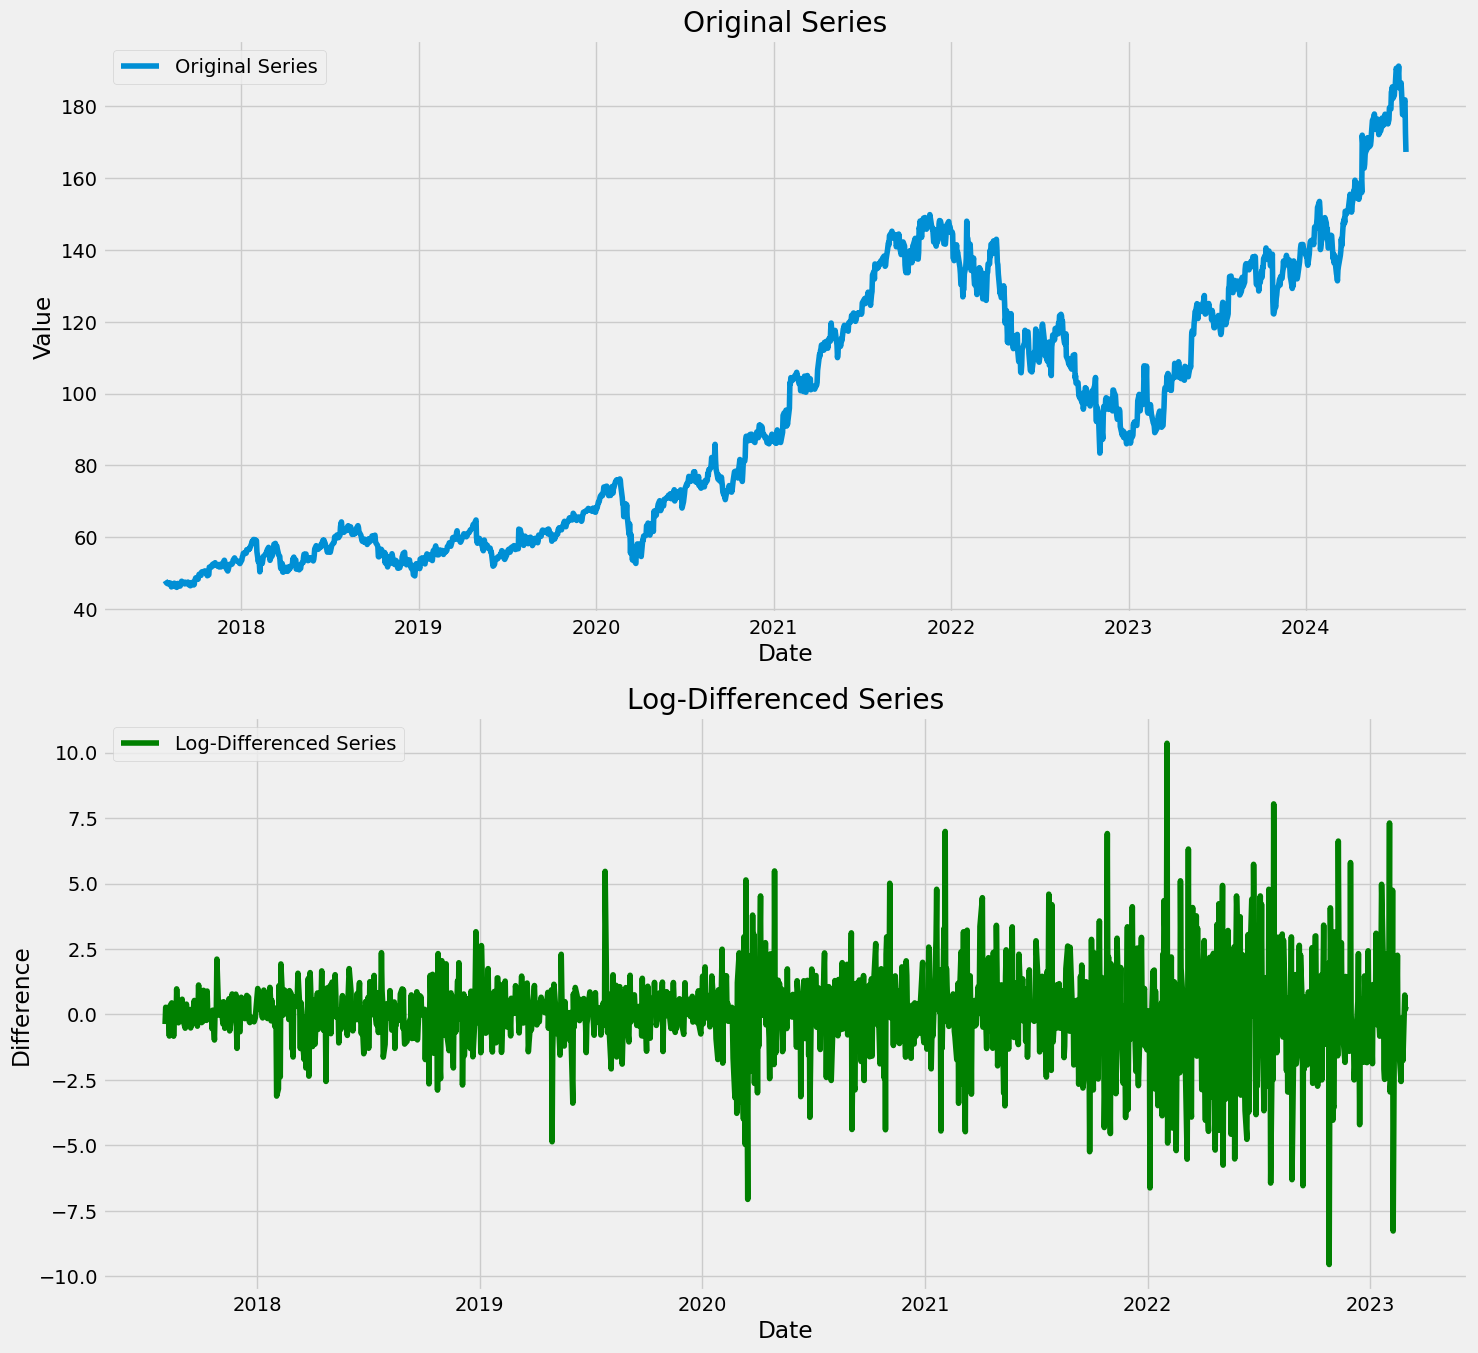

In [13]:
# Plotting
plt.figure(figsize=(15, 20))

# Original Series
plt.subplot(311)
plt.plot(df_close, label='Original Series')
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Original Series
plt.subplot(312)
plt.plot(train_data_log, label='Original Series')
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Differenced Series
plt.subplot(313)
plt.plot(train_data_log_diff, label='Log-Differenced Series', color='green')
plt.title('Log-Differenced Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Modeling - ARIMA <a class="anchor" id="3"></a>

### Auto_Arima helps us identify the best p,d,q

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_data_log_diff, 
                   seasonal=False,  # Change to True if you have seasonal data
                   trace=True,
                   m=24,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True,)

p = model.order[0]
d = model.order[1]
q = model.order[2]

C:\Users\imdan\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5512.303, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5512.978, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5509.706, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5509.526, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5508.335, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5510.026, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5510.048, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5511.102, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5511.343, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5509.656, Time=0.23 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.967 seconds


### Fitting the model

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_log_diff,
                order=(p, d, q) 
             )
fitted = model.fit() 
print(fitted.summary())

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1403
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2750.828
Date:                Fri, 26 Jul 2024   AIC                           5509.656
Time:                        21:26:36   BIC                           5530.641
Sample:                             0   HQIC                          5517.500
                               - 1403                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0308      0.038      0.803      0.422      -0.044       0.106
ar.L1          0.6958      0.118      5.904      0.000       0.465       0.927
ma.L1         -0.7530      0.109     -6.930      0.0

Forecast to predict the trend

In [16]:
forecast_steps = len(test_data)  # Number of periods to forecast
result = fitted.forecast(forecast_steps, alpha = 0.05)
conf_ins = fitted.get_forecast(forecast_steps).summary_frame()


C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [17]:
#undo differencing
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

#take the initial value of test_data_log
test_data_log = np.log(test_data)

inversed_result = diff_inv(result , test_data_log['Close'][0])
inversed_result = pd.Series(inversed_result)
inversed_result = inversed_result[:len(test_data)]
inversed_result.index = test_data.index

result = inversed_result
#Undo logs
#result = np.exp(inversed_result)


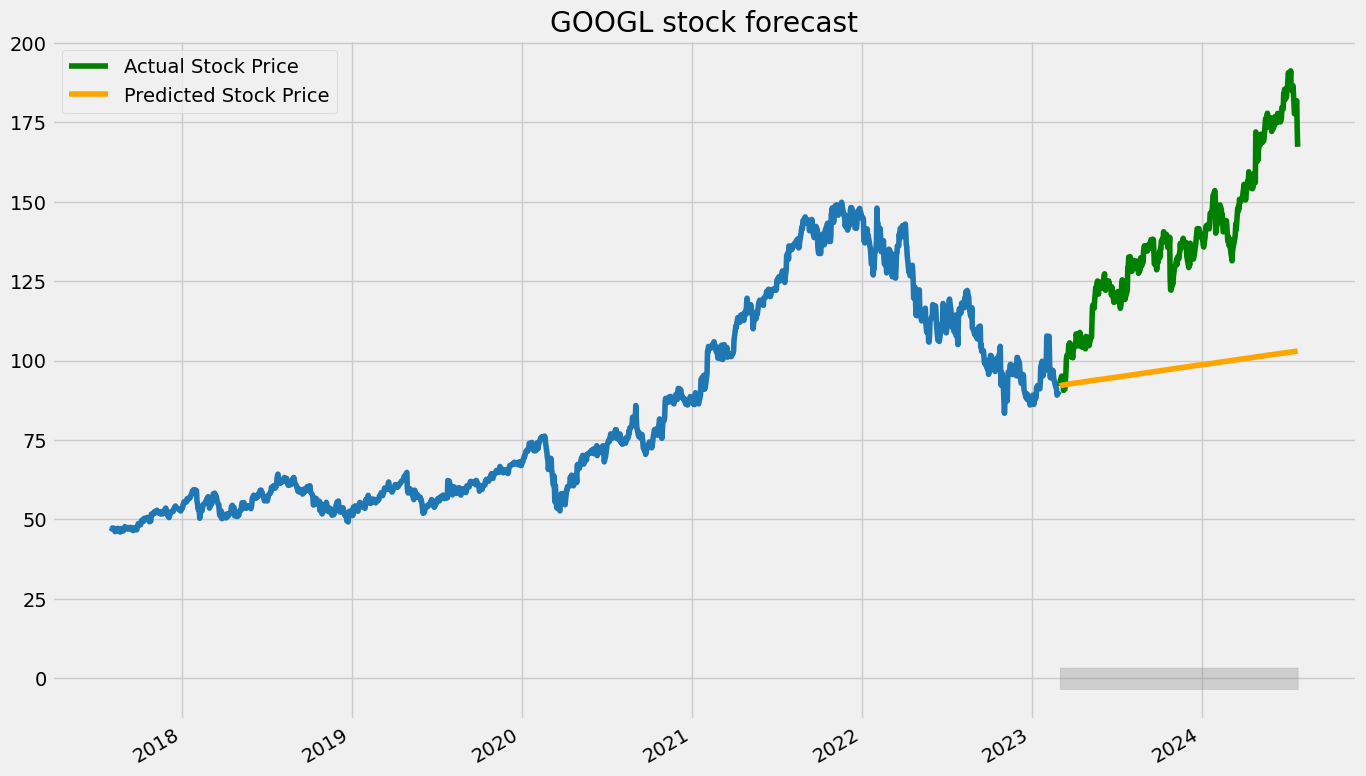

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(train_data.index, train_data.values, color = '#1f77b4')
ax.plot(test_data.index, test_data.values, label='Actual Stock Price',color = 'green')
ax.plot(test_data.index, result, label='Predicted Stock Price', color = 'orange')
ax.fill_between(test_data.index,conf_ins['mean_ci_lower'],conf_ins['mean_ci_upper'],color='grey', alpha=0.3)
plt.title('{} stock forecast'.format(stock))
ax.legend()
fig.autofmt_xdate()
plt.show()

### Future predictions

In [19]:
future_forecast_steps = 600  # Number of periods to forecast
future_result = fitted.forecast(future_forecast_steps, alpha = 0.05)
future_conf_ins = fitted.get_forecast(future_forecast_steps).summary_frame()

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [20]:
future_dates = pd.date_range(start=test_data.index[0] + pd.Timedelta(days=1), periods=future_forecast_steps, freq='B')
future_dates = pd.DataFrame(index=future_dates, columns=df.columns)

In [21]:
future_inversed_series = diff_inv(future_result , test_data['Close'][0])
future_inversed_series = pd.Series(future_inversed_series)
future_inversed_series = future_inversed_series[:len(future_result)]
future_inversed_series.index = future_dates.index
future_result = future_inversed_series

#Undo logs
#future_result = np.exp(future_inversed_series)

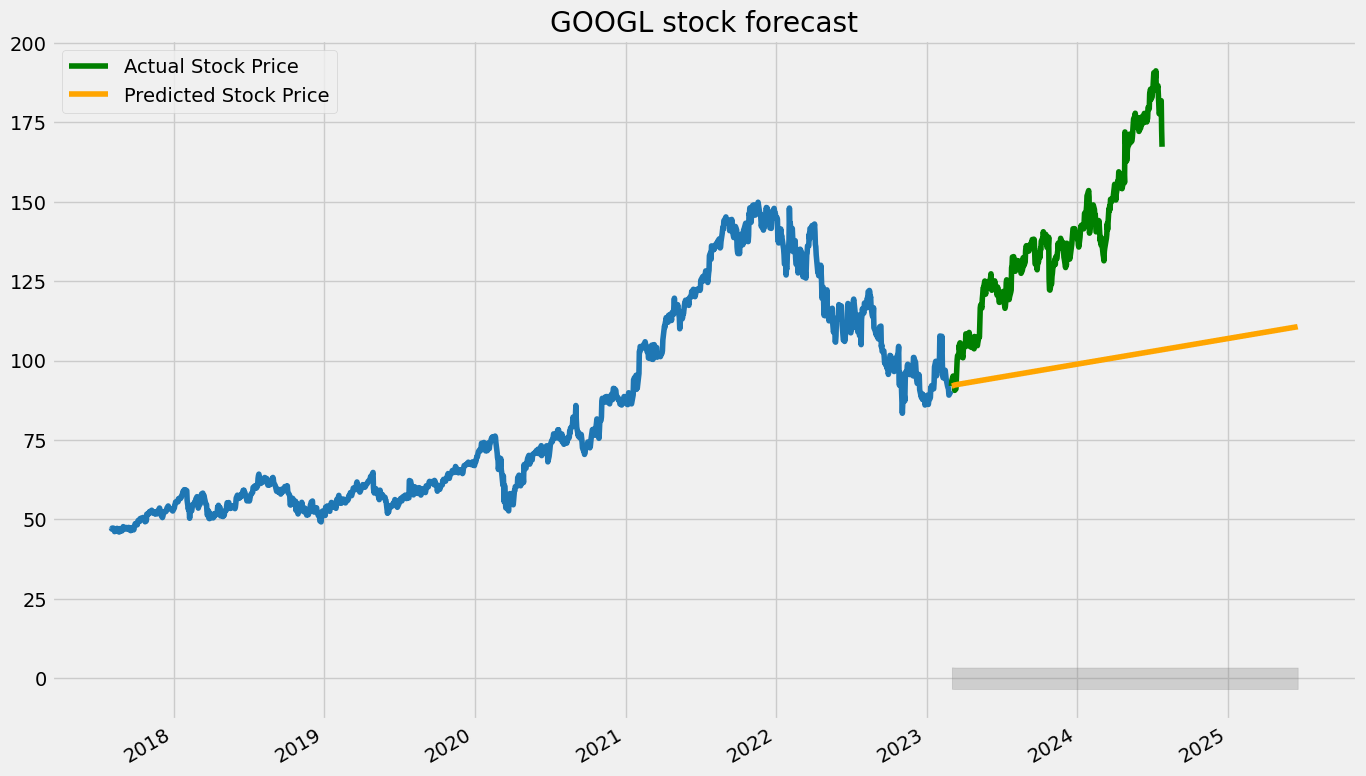

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(train_data.index, train_data.values, color = '#1f77b4')
ax.plot(test_data.index, test_data.values, label='Actual Stock Price',color = 'green')
ax.plot(future_dates.index, future_result, label='Predicted Stock Price', color = 'orange')
ax.fill_between(future_dates.index,future_conf_ins['mean_ci_lower'],future_conf_ins['mean_ci_upper'],color='grey', alpha=0.3)
plt.title('{} stock forecast'.format(stock))
ax.legend()
fig.autofmt_xdate()
plt.show()

In [23]:
specific_date_value = future_result['2025-01-01']
print(f"Forecasted value for 2025-01-01: {specific_date_value}")

Forecasted value for 2025-01-01: 106.94271372828953


## ARIMA Results <a class="anchor" id="3.a"></a>

## Metrics

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, result)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, result)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, result))
print('RMSE: '+str(rmse))

test_series = (test_data['Close'].values)
test=result-test_series
test_data_abs = np.abs(test_data).values

mape = np.mean(np.abs(test).values)/test_data_abs
mape = np.mean(mape)
print('MAPE: '+str(mape))

ARIMA_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

MSE: 2028.5454185617675
MAE: 40.34859392060414
RMSE: 45.03937631186479
MAPE: 0.3007238902323725


In [25]:
ARIMA_results

,Metric,Value
0,MSE,2028.545419
1,MAE,40.348594
2,RMSE,45.039376
3,MAPE,0.300724


MAPE (Mean Absolute Percentage Error): This measures the average absolute percentage difference between the actual and predicted stock prices. It gives an idea of the error relative to the size of the stock prices. And given that our model's MAPE is 2.1% difference between Actual and Prediction is pretty impressive.

The error metrics (MSE, MAE, RMSE, MAPE) are relatively low, indicating that the model's predictions are reasonably accurate, though not perfect.

Overall, the graph and metrics together provide a comprehensive view of how well the forecasting model performs and its expected accuracy in predicting future stock prices.

# Modeling - Facebook Prophet <a class="anchor" id="4"></a>

Prophet only takes [ds] and [y], so we need to rename our train_data columns

In [26]:
train_data = train_data.reset_index()
train_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [27]:
train_data.head()

,ds,y
0,2017-08-02,47.382000
1,2017-08-03,47.014999
2,2017-08-04,47.289501
3,2017-08-07,47.287498
4,2017-08-08,47.209499


Define functions for model testing and model evaluation

In [28]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np

def train_prophet_model(train_data, changepoint_prior_scale=0.05, seasonality_prior_scale=10, holidays_prior_scale=10,
                        seasonality_mode='additive'):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)
    return model

def evaluate_model(train_df, model):
    df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
    return df_p

Finding the best parameters

In [29]:
from itertools import product

changepoint_prior_scales = [0.01, 0.05, 0.1]
seasonality_prior_scales = [1, 10, 100]
holidays_prior_scales = [1, 10, 100]
seasonality_modes = ['additive', 'multiplicative']

results = []

for cps, sps, hps, sm in product(changepoint_prior_scales, seasonality_prior_scales, holidays_prior_scales, seasonality_modes):
    model = train_prophet_model(train_data, changepoint_prior_scale=cps, seasonality_prior_scale=sps, 
                                holidays_prior_scale=hps, seasonality_mode=sm)
    metrics = evaluate_model(train_data, model)
    metrics['changepoint_prior_scale'] = cps
    metrics['seasonality_prior_scale'] = sps
    metrics['holidays_prior_scale'] = hps
    metrics['seasonality_mode'] = sm
    results.append(metrics)

results_df = pd.concat(results, ignore_index=True)

21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/10 [00:00<?, ?it/s]

21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
21:27:26 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:29 - cmdstanpy - INFO - Chain [1] done processing
21:27:29 - cmdstanpy - INFO - Chain [1] start processing
21:27:29 - cmdstanpy - INFO - Chain [1] done processing
21:27:29 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1] done processing
21:27:30 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:41 - cmdstanpy - INFO - Chain [1] start processing
21:27:41 - cmdstanpy - INFO - Chain [1] done processing
21:27:41 - cmdstanpy - INFO - Chain [1] start processing
21:27:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:42 - cmdstanpy - INFO - Chain [1] start processing
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
21:27:42 - cmdstanpy - INFO - Chain [1] start processing
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing
21:27:43 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing
21:27:43 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing
21:27:43 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
21:27:44 - cmdstanpy - INFO - Chain [1] start processing
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
21:27:44 - cmdstanpy - INFO - Chain [1] start processing
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
21:27:45 - cmdstanpy - INFO - Chain [1] start processing
21:27:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:54 - cmdstanpy - INFO - Chain [1] done processing
21:27:54 - cmdstanpy - INFO - Chain [1] start processing
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:27:56 - cmdstanpy - INFO - Chain [1] done processing
21:27:56 - cmdstanpy - INFO - Chain [1] start processing
21:27:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:27:59 - cmdstanpy - INFO - Chain [1] start processing
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
21:27:59 - cmdstanpy - INFO - Chain [1] start processing
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:05 - cmdstanpy - INFO - Chain [1] start processing
21:28:05 - cmdstanpy - INFO - Chain [1] done processing
21:28:05 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:07 - cmdstanpy - INFO - Chain [1] done processing
21:28:07 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:09 - cmdstanpy - INFO - Chain [1] done processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing
21:28:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing
21:28:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:17 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:17 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:17 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:18 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:20 - cmdstanpy - INFO - Chain [1] start processing
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
21:28:22 - cmdstanpy - INFO - Chain [1] start processing
21:28:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing
21:28:27 - cmdstanpy - INFO - Chain [1] done processing
21:28:27 - cmdstanpy - INFO - Chain [1] start processing
21:28:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:30 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:30 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:30 - cmdstanpy - INFO - Chain [1] start processing
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
21:28:31 - cmdstanpy - INFO - Chain [1] start processing
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:33 - cmdstanpy - INFO - Chain [1] done processing
21:28:33 - cmdstanpy - INFO - Chain [1] start processing
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
21:28:34 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing
21:28:42 - cmdstanpy - INFO - Chain [1] done processing
21:28:42 - cmdstanpy - INFO - Chain [1] start processing
21:28:42 - cmdstanpy - INFO - Chain [1] done processing
21:28:42 - cmdstanpy - INFO - Chain [1] start processing
21:28:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:49 - cmdstanpy - INFO - Chain [1] done processing
21:28:49 - cmdstanpy - INFO - Chain [1] start processing
21:28:50 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
21:28:51 - cmdstanpy - INFO - Chain [1] start processing
21:28:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:56 - cmdstanpy - INFO - Chain [1] start processing
21:28:56 - cmdstanpy - INFO - Chain [1] done processing
21:28:56 - cmdstanpy - INFO - Chain [1] start processing
21:28:56 - cmdstanpy - INFO - Chain [1] done processing
21:28:56 - cmdstanpy - INFO - Chain [1] start processing
21:28:56 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:00 - cmdstanpy - INFO - Chain [1] start processing
21:29:00 - cmdstanpy - INFO - Chain [1] done processing
21:29:00 - cmdstanpy - INFO - Chain [1] start processing
21:29:00 - cmdstanpy - INFO - Chain [1] done processing
21:29:00 - cmdstanpy - INFO - Chain [1] start processing
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
21:29:01 - cmdstanpy - INFO - Chain [1] start processing
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:03 - cmdstanpy - INFO - Chain [1] start processing
21:29:04 - cmdstanpy - INFO - Chain [1] done processing
21:29:04 - cmdstanpy - INFO - Chain [1] start processing
21:29:05 - cmdstanpy - INFO - Chain [1] done processing
21:29:05 - cmdstanpy - INFO - Chain [1] start processing
21:29:06 - cmdstanpy - INFO - Chain [1] done processing
21:29:06 - cmdstanpy - INFO - Chain [1] start processing
21:29:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:18 - cmdstanpy - INFO - Chain [1] start processing
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing
21:29:22 - cmdstanpy - INFO - Chain [1] done processing
21:29:22 - cmdstanpy - INFO - Chain [1] start processing
21:29:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:26 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:26 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:26 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:27 - cmdstanpy - INFO - Chain [1] start processing
21:29:27 - cmdstanpy - INFO - Chain [1] done processing
21:29:27 - cmdstanpy - INFO - Chain [1] start processing
21:29:27 - cmdstanpy - INFO - Chain [1] done processing
21:29:27 - cmdstanpy - INFO - Chain [1] start processing
21:29:28 - cmdstanpy - INFO - Chain [1] done processing
21:29:28 - cmdstanpy - INFO - Chain [1] start processing
21:29:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:30 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:33 - cmdstanpy - INFO - Chain [1] done processing
21:29:33 - cmdstanpy - INFO - Chain [1] start processing
21:29:34 - cmdstanpy - INFO - Chain [1] done processing
21:29:34 - cmdstanpy - INFO - Chain [1] start processing
21:29:35 - cmdstanpy - INFO - Chain [1] done processing
21:29:35 - cmdstanpy - INFO - Chain [1] start processing
21:29:37 - cmdstanpy - INFO - Chain [1] done processing
21:29:37 - cmdstanpy - INFO - Chain [1] start processing
21:29:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing
21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:42 - cmdstanpy - INFO - Chain [1] start processing
21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:42 - cmdstanpy - INFO - Chain [1] start processing
21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:43 - cmdstanpy - INFO - Chain [1] start processing
21:29:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:45 - cmdstanpy - INFO - Chain [1] start processing
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
21:29:45 - cmdstanpy - INFO - Chain [1] start processing
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:47 - cmdstanpy - INFO - Chain [1] done processing
21:29:47 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:49 - cmdstanpy - INFO - Chain [1] done processing
21:29:49 - cmdstanpy - INFO - Chain [1] start processing
21:29:50 - cmdstanpy - INFO - Chain [1] done processing
21:29:50 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
21:29:52 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing
21:29:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:02 - cmdstanpy - INFO - Chain [1] start processing
21:30:02 - cmdstanpy - INFO - Chain [1] done processing
21:30:02 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing
21:30:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing
21:30:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing
21:30:10 - cmdstanpy - INFO - Chain [1] start processing
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
21:30:10 - cmdstanpy - INFO - Chain [1] start processing
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
21:30:10 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:12 - cmdstanpy - INFO - Chain [1] done processing
21:30:12 - cmdstanpy - INFO - Chain [1] start processing
21:30:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:14 - cmdstanpy - INFO - Chain [1] start processing
21:30:14 - cmdstanpy - INFO - Chain [1] done processing
21:30:14 - cmdstanpy - INFO - Chain [1] start processing
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] start processing
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing
21:30:19 - cmdstanpy - INFO - Chain [1] done processing
21:30:20 - cmdstanpy - INFO - Chain [1] start processing
21:30:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
21:30:24 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
21:30:24 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing
21:30:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
21:30:29 - cmdstanpy - INFO - Chain [1] start processing
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing
21:30:30 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing
21:30:31 - cmdstanpy - INFO - Chain [1] done processing
21:30:31 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:34 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:36 - cmdstanpy - INFO - Chain [1] start processing
21:30:36 - cmdstanpy - INFO - Chain [1] done processing
21:30:36 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:42 - cmdstanpy - INFO - Chain [1] start processing
21:30:42 - cmdstanpy - INFO - Chain [1] done processing
21:30:42 - cmdstanpy - INFO - Chain [1] start processing
21:30:42 - cmdstanpy - INFO - Chain [1] done processing
21:30:42 - cmdstanpy - INFO - Chain [1] start processing
21:30:43 - cmdstanpy - INFO - Chain [1] done processing
21:30:43 - cmdstanpy - INFO - Chain [1] start processing
21:30:44 - cmdstanpy - INFO - Chain [1] done processing
21:30:44 - cmdstanpy - INFO - Chain [1] start processing
21:30:45 - cmdstanpy - INFO - Chain [1] done processing
21:30:45 - cmdstanpy - INFO - Chain [1] start processing
21:30:46 - cmdstanpy - INFO - Chain [1] done processing
21:30:46 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:48 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:52 - cmdstanpy - INFO - Chain [1] start processing
21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:52 - cmdstanpy - INFO - Chain [1] start processing
21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:52 - cmdstanpy - INFO - Chain [1] start processing
21:30:53 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing
21:30:53 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing
21:30:53 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:30:57 - cmdstanpy - INFO - Chain [1] start processing
21:30:57 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing
21:30:58 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing
21:30:58 - cmdstanpy - INFO - Chain [1] done processing
21:30:59 - cmdstanpy - INFO - Chain [1] start processing
21:30:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:00 - cmdstanpy - INFO - Chain [1] start processing
21:31:00 - cmdstanpy - INFO - Chain [1] done processing
21:31:00 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:04 - cmdstanpy - INFO - Chain [1] done processing
21:31:04 - cmdstanpy - INFO - Chain [1] start processing
21:31:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:09 - cmdstanpy - INFO - Chain [1] start processing
21:31:09 - cmdstanpy - INFO - Chain [1] done processing
21:31:09 - cmdstanpy - INFO - Chain [1] start processing
21:31:09 - cmdstanpy - INFO - Chain [1] done processing
21:31:09 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:11 - cmdstanpy - INFO - Chain [1] done processing
21:31:11 - cmdstanpy - INFO - Chain [1] start processing
21:31:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:16 - cmdstanpy - INFO - Chain [1] done processing
21:31:16 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:18 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:23 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:26 - cmdstanpy - INFO - Chain [1] done processing
21:31:26 - cmdstanpy - INFO - Chain [1] start processing
21:31:26 - cmdstanpy - INFO - Chain [1] done processing
21:31:27 - cmdstanpy - INFO - Chain [1] start processing
21:31:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:29 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:30 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:30 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:30 - cmdstanpy - INFO - Chain [1] start processing
21:31:31 - cmdstanpy - INFO - Chain [1] done processing
21:31:31 - cmdstanpy - INFO - Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing
21:31:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing
21:31:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:46 - cmdstanpy - INFO - Chain [1] done processing
21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:46 - cmdstanpy - INFO - Chain [1] done processing
21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - INFO - Chain [1] start processing
21:31:48 - cmdstanpy - INFO - Chain [1] done processing
21:31:48 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing
21:31:51 - cmdstanpy - INFO - Chain [1] start processing
21:31:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:31:54 - cmdstanpy - INFO - Chain [1] start processing
21:31:54 - cmdstanpy - INFO - Chain [1] done processing
21:31:54 - cmdstanpy - INFO - Chain [1] start processing
21:31:54 - cmdstanpy - INFO - Chain [1] done processing
21:31:54 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing
21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing
21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing
21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
21:31:57 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:02 - cmdstanpy - INFO - Chain [1] done processing
21:32:02 - cmdstanpy - INFO - Chain [1] start processing
21:32:03 - cmdstanpy - INFO - Chain [1] done processing
21:32:03 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:06 - cmdstanpy - INFO - Chain [1] done processing
21:32:06 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1]

Considering the nature of stock prediction, where both the magnitude of errors and their impact are crucial, RMSE is generally the best metric. It provides a balance between interpretability and sensitivity to large errors, making it a comprehensive measure for evaluating our model

In [30]:
#finds best RMSE
best_model_params = results_df.loc[results_df['rmse'].idxmin()]

In [31]:
best_model_params

horizon                    6 days 00:00:00
mse                              16.758904
rmse                              4.093764
mae                               2.604676
mape                              0.027423
mdape                             0.019468
smape                             0.027857
coverage                              0.55
changepoint_prior_scale                0.1
seasonality_prior_scale                100
holidays_prior_scale                     1
seasonality_mode            multiplicative
Name: 1375, dtype: object

In [32]:
best_params = {
    'changepoint_prior_scale': best_model_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_model_params['seasonality_prior_scale'],
    'holidays_prior_scale': best_model_params['holidays_prior_scale'],
    'seasonality_mode': best_model_params['seasonality_mode']
}

final_model = train_prophet_model(train_data, **best_params)

21:32:09 - cmdstanpy - INFO - Chain [1] start processing
21:32:10 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
test_data = test_data.reset_index()
test_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [34]:
forecast = final_model.predict(test_data)

In [35]:
matched_data = test_data.merge(forecast, on='ds', how='left')

## Propret Results <a class="anchor" id="4.a"></a>

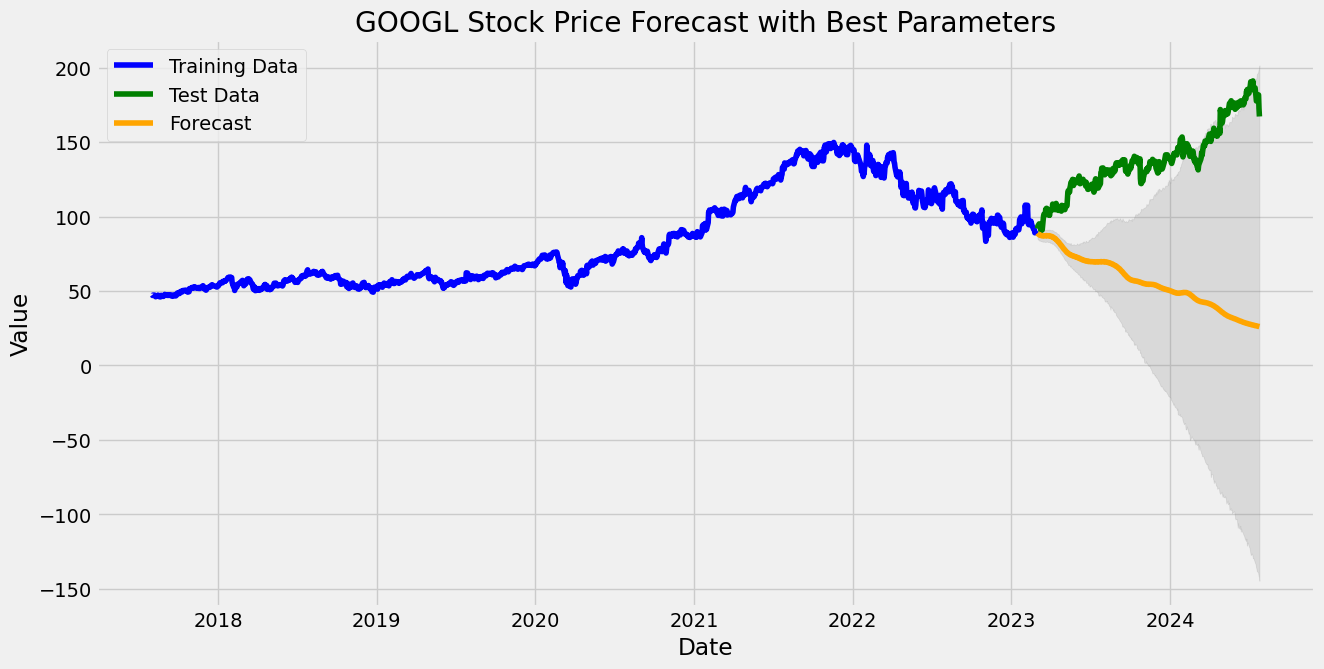

In [45]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(matched_data ['ds'], matched_data ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(matched_data ['ds'], matched_data ['yhat_lower'], matched_data ['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
#plt.ylim(0,80)

plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_y = test_data['y']  # Actual values
predicted_y = matched_data['yhat']  # Predicted values

mse = mean_squared_error(test_y, predicted_y)
mae = mean_absolute_error(test_y, predicted_y)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(test_y - predicted_y) / np.abs(test_y))

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

PROPHET_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

MSE: 8306.100507102441
MAE: 81.8011220300473
RMSE: 91.13781052396662
MAPE: 0.5605337411467258


In [38]:
PROPHET_results

,Metric,Value
0,MSE,8306.100507
1,MAE,81.801122
2,RMSE,91.137811
3,MAPE,0.560534


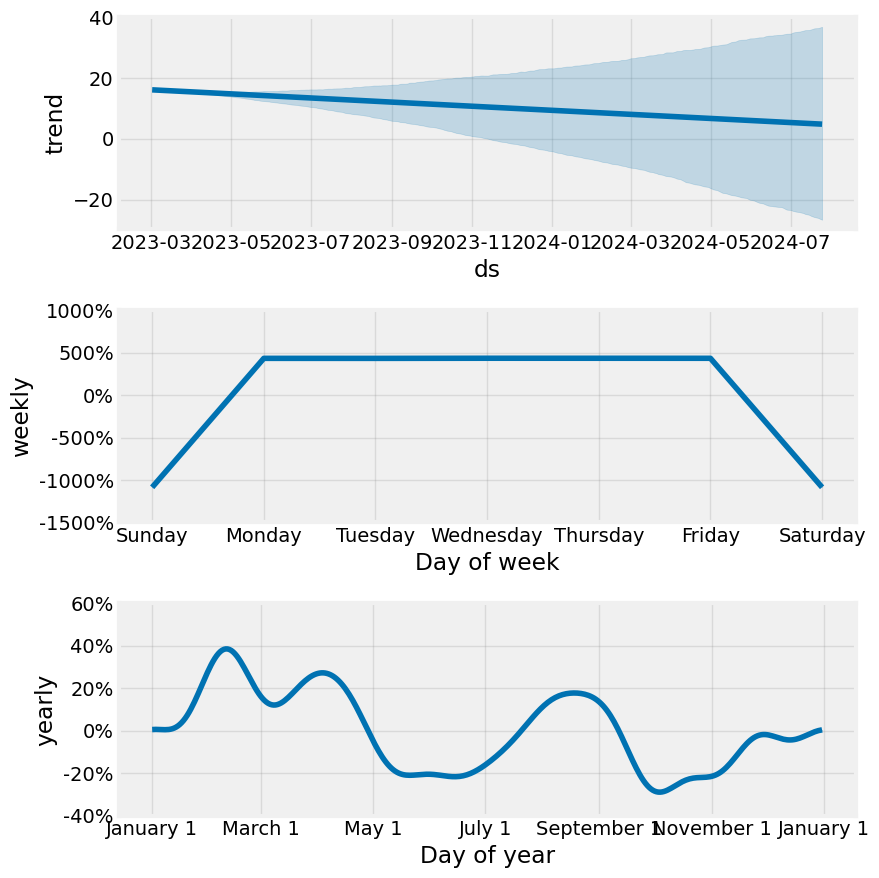

In [39]:
fig = model.plot_components(matched_data)

plt.show()

Predicting Future values

In [40]:
future = final_model.make_future_dataframe(periods= 800,freq='D') 

# Predict future values
forecast = final_model.predict(future)

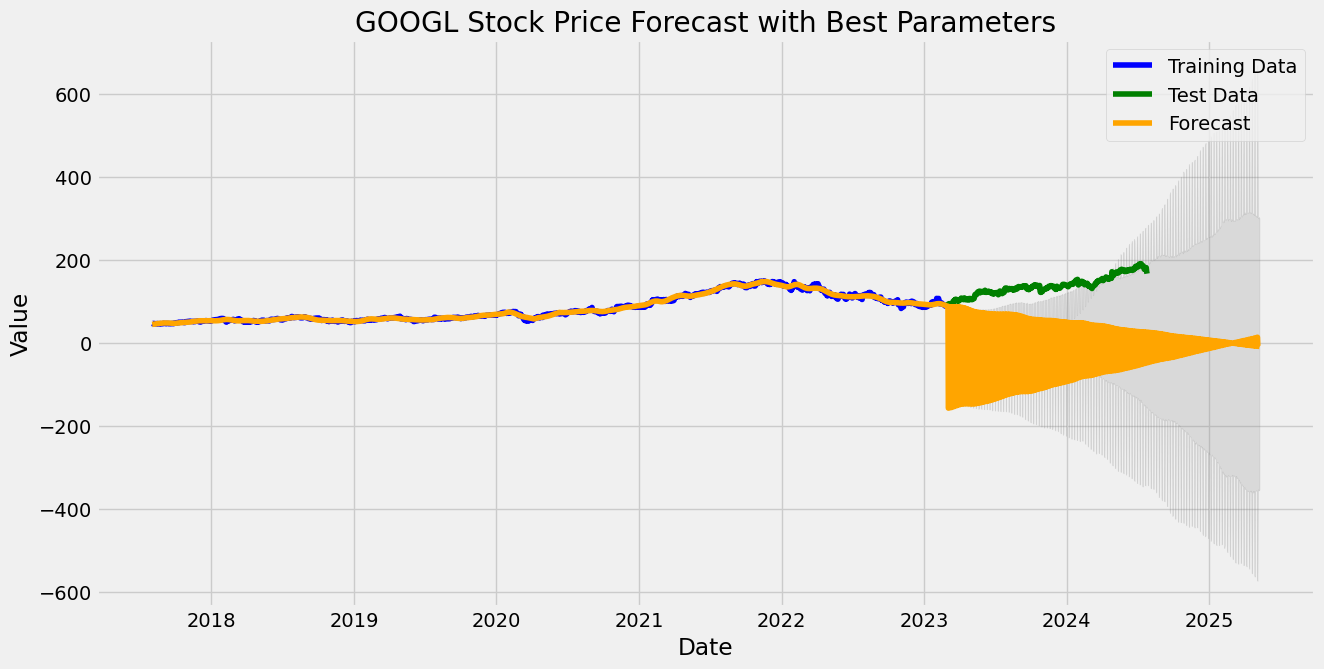

In [41]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(forecast ['ds'], forecast ['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
#plt.ylim(0,400)

plt.show()

In [42]:
PROPHET_results

,Metric,Value
0,MSE,8306.100507
1,MAE,81.801122
2,RMSE,91.137811
3,MAPE,0.560534


## Comparative Analysis <a class="anchor" id="5"></a>

  Metric    Prophet     ARIMA
0    MSE  14.090119  4.287156
1    MAE   2.773540  1.550832
2   RMSE   3.753681  2.070545
3   MAPE   0.043234  0.024767


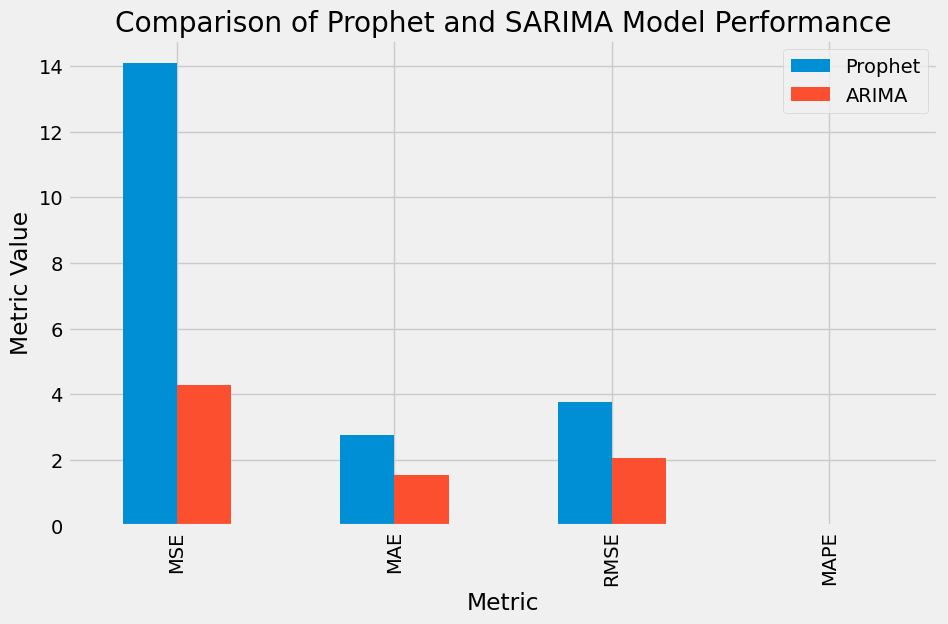

In [43]:

# Data
data = {
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Prophet': [14.090119, 2.773540, 3.753681, 0.043234],
    'ARIMA': [4.287156021439776, 1.550832438078203, 2.070544861006343, 0.0247668892445323]
}

# Create DataFrame
overall_results = pd.DataFrame(data)

# Display DataFrame
print(overall_results)

# Plotting
overall_results.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Prophet and SARIMA Model Performance')
plt.ylabel('Metric Value')
plt.show()

SARIMA has a lower MSE, indicating it has better overall accuracy in capturing the variance in the data. <br>
SARIMA has a lower MAE, indicating it has better accuracy in terms of absolute differences between the predicted and actual values.<br>
SARIMA has a lower RMSE, indicating it has better accuracy and lower prediction error magnitude.<br>
SARIMA has a lower MAPE, indicating it has better accuracy in terms of percentage error. <br>



Based on the provided metrics, the SARIMA model outperforms the Prophet model across all evaluation metrics (MSE, MAE, RMSE, and MAPE). Therefore, SARIMA would be the preferred model for your time series forecasting task. <br>




In [44]:
overall_results

,Metric,Prophet,ARIMA
0,MSE,14.090119,4.287156
1,MAE,2.773540,1.550832
2,RMSE,3.753681,2.070545
3,MAPE,0.043234,0.024767
